In [1]:
%matplotlib inline

In [2]:
import logging

from platform import python_version
import random


import numpy as np

import torch
import sklearn
import torch.nn as nn
import pandas as pd
import matplotlib

from torch.autograd import Variable

import transformers


from preprocessing import preprocessing
from tokenize_and_pad_text import *
from train_model import KimCNN, train_test_model

In [3]:
random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [4]:
threshold = 0.9

model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights = 'bert-base-uncased'
target_columns = ['label']

max_seq = 128
bert_batch_size = 16

kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

n_epochs = 10
batch_size = 64
lr = 0.001
optimizer = torch.optim.Adam
loss_fn = nn.BCELoss()

version
python version==3.7.5
pandas==1.2.0
numpy==1.19.4
torch==1.7.1+cu101
sklearn==0.24.0
transformers==3.5.0
matplotlib==3.3.3

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-DGXS-32GB

use reviews.csv data
make id dictionary and count id frequency of id ...


100%|██████████| 358957/358957 [00:06<00:00, 53191.51it/s]


label is changed!!! (-1, 1) => (0, 1)

length of real review : 322097, length of fake review : 36860

train val test split
make train data ...


0it [00:00, ?it/s]


make valid data ...


100%|██████████| 124/124 [00:04<00:00, 26.59it/s]


make train data ...


100%|██████████| 249/249 [00:13<00:00, 18.90it/s]


train model ...
Epoch 1 Train loss: 0.59. Validation loss: 0.69. Elapsed time: 0.01.
Epoch 2 Train loss: 0.61. Validation loss: 0.69. Elapsed time: 0.00.
Epoch 3 Train loss: 0.60. Validation loss: 0.69. Elapsed time: 0.00.
Epoch 4 Train loss: 0.43. Validation loss: 0.69. Elapsed time: 0.00.
Epoch 5 Train loss: 0.32. Validation loss: 0.68. Elapsed time: 0.00.
Epoch 6 Train loss: 0.16. Validation loss: 0.67. Elapsed time: 0.00.
Epoch 7 Train loss: 0.12. Validation loss: 0.67. Elapsed time: 0.00.
Epoch 8 Train loss: 0.17. Validation loss: 0.66. Elapsed time: 0.00.
Epoch 9 Train loss: 0.18. Validation loss: 0.67. Elapsed time: 0.00.
Epoch 10 Train loss: 0.03. Validation loss: 0.67. Elapsed time: 0.00.


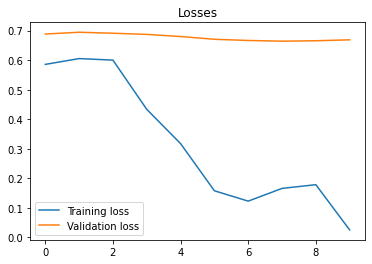

test model ...
threshold : 0.9,	auc ascores : 0.644139875


In [5]:
print('version')
print(f"python version=={python_version()}")
print(f"pandas=={pd.__version__}")
print(f"numpy=={np.__version__}")
print(f"torch=={torch.__version__}")
print(f"sklearn=={sklearn.__version__}")
print(f"transformers=={transformers.__version__}")
print(f"matplotlib=={matplotlib.__version__}",end='\n\n')

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print(f'There are {torch.cuda.device_count()} GPU(s) available.')

    print(f'We will use the GPU: {torch.cuda.get_device_name(0)}', end='\n\n')

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu", end='\n\n')
    
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

data_path = '../reviews.csv'
data_name = data_path.split('/')[-1]
print(f'use {data_name} data', end='\n')

df = pd.read_csv(data_path)

preprocessing_class = preprocessing(df)

df_train, df_val, df_test = preprocessing_class.preprocessing_all()

print('make train data ...')
x_train, y_train = tokenize_and_pad_text_bert(df_train, device, model_class, tokenizer_class, pretrained_weights,
                                            max_seq=max_seq, batch_size=bert_batch_size, target_columns=target_columns)

print('make valid data ...')
x_val, y_val = tokenize_and_pad_text_bert(df_val, device, model_class, tokenizer_class, pretrained_weights,
                                            max_seq=max_seq, batch_size=bert_batch_size, target_columns=target_columns)

print('make train data ...')
x_test, y_test = tokenize_and_pad_text_bert(df_test, device, model_class, tokenizer_class, pretrained_weights,
                                            max_seq=max_seq, batch_size=bert_batch_size, target_columns=target_columns)
                                 
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]

model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

model = model.to(device)

# train and test
review_classification_model = train_test_model(model)
review_classification_model.train(x_train, y_train, x_val, y_val)
auc_scores = review_classification_model.test(x_test, y_test)

print(f'threshold : {threshold},\tauc ascores : {auc_scores}')